In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn .metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score
from sklearn.svm import SVC

In [3]:
training_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
output_data=pd.read_csv("gender_submission.csv")

In [4]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<Axes: xlabel='Survived', ylabel='count'>

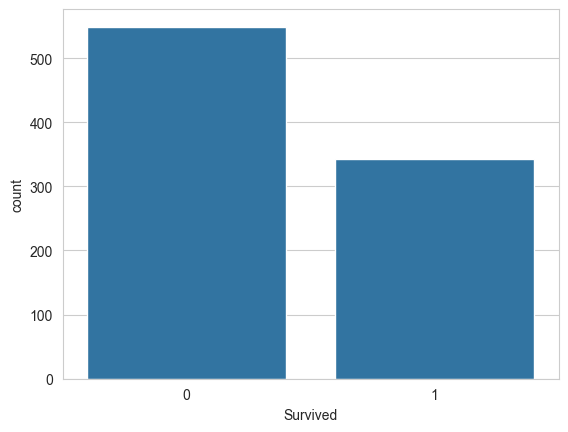

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=training_data)


In [7]:
filtered_data = training_data[~training_data['Embarked'].isin(['C', 'S', 'Q'])]
filtered_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


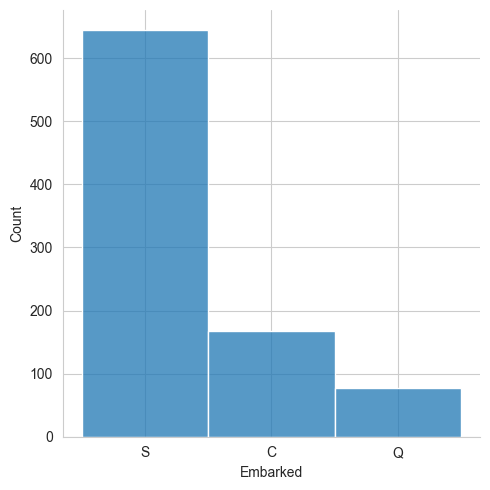

In [8]:
sns.displot(data=training_data,x='Embarked')

In [9]:
embarked_mode = training_data['Embarked'].mode()[0]

# Fill NaN values in 'Embarked' with the mode
training_data['Embarked'].fillna(embarked_mode, inplace=True)

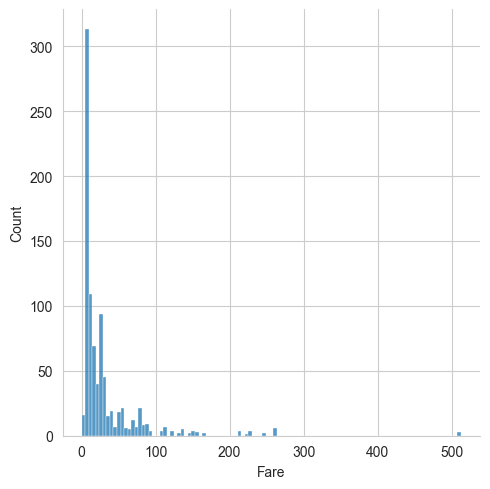

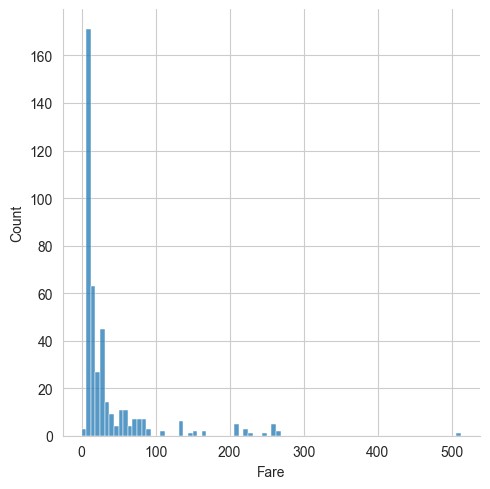

In [10]:
sns.displot(training_data['Fare'])
sns.displot(test_data['Fare'])

In [11]:
training_data[training_data["Fare"]>300]



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


<Axes: xlabel='Survived', ylabel='count'>

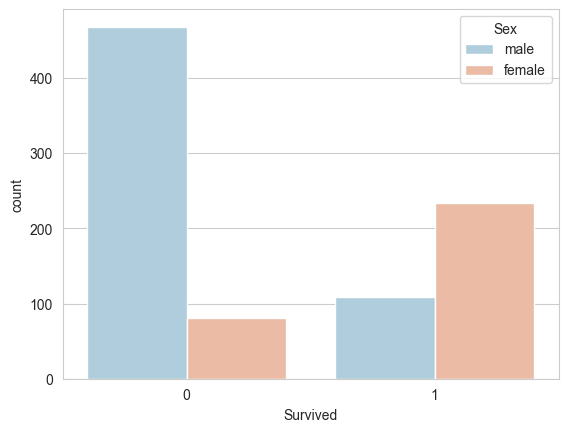

In [12]:
sns.countplot(x='Survived',data=training_data,hue="Sex",palette="RdBu_r")

<Axes: >

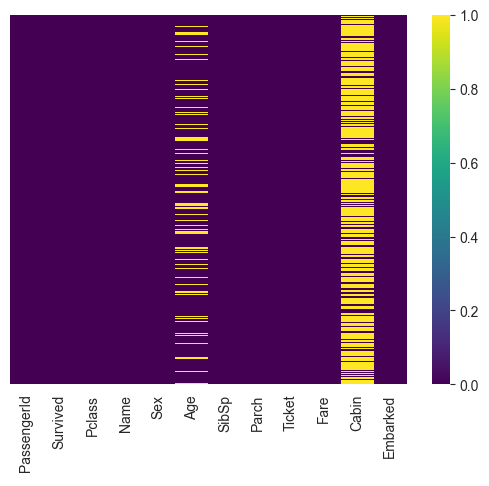

In [13]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

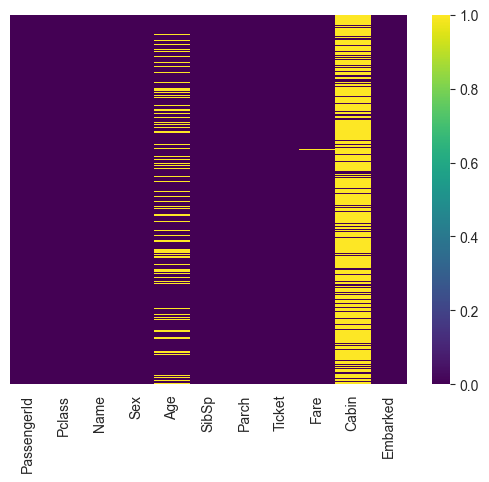

In [14]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

In [15]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
def add_title_and_encode(data):
    # Extract titles using a raw string for the regex pattern
    data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    # Apply OneHotEncoder to the 'Title' column
    encoder_title = OneHotEncoder(sparse_output=False, drop='first')
    title_encoded = encoder_title.fit_transform(data[['Title']])
    title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
    data = pd.concat([data, title_encoded_df], axis=1)
    data.drop('Title', axis=1, inplace=True)
    
    # Check for missing values before encoding 'Embarked'
    data['Embarked'].fillna('Missing', inplace=True)
    encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
    embarked_encoded = encoder_embarked.fit_transform(data[['Embarked']])
    embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)
    data = pd.concat([data, embarked_encoded_df], axis=1)
    
    # Encode 'Sex' directly
    data['Sex'] = data['Sex'].map({'male': 1, 'female': 0}).astype(int)
    
    # Handle 'Pclass' similarly with missing value handling
    encoder_Pclass = OneHotEncoder(sparse_output=False, drop='first')
    Pclass_encoded = encoder_Pclass.fit_transform(data[['Pclass']])
    Pclass_encoded_df = pd.DataFrame(Pclass_encoded, columns=encoder_Pclass.get_feature_names_out(['Pclass'])).astype(int)
    data = pd.concat([data, Pclass_encoded_df], axis=1)
    
    # Drop original columns if they exist
    columns_to_drop = ['Pclass', 'Embarked', 'Name', 'Cabin', 'Ticket', 'PassengerId']
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], axis=1, inplace=True)
    
    return data

# Apply the function to training and test data
training_data = add_title_and_encode(training_data)
test_data = add_title_and_encode(test_data)


In [18]:
training_data

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,1,22.0,1,0,7.2500,0,1,0,0,0,1,0,1
1,2,1,0,38.0,1,0,71.2833,0,0,1,0,0,0,0,0
2,3,1,0,26.0,0,0,7.9250,1,0,0,0,0,1,0,1
3,4,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0
4,5,0,1,35.0,0,0,8.0500,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,1,27.0,0,0,13.0000,0,0,0,1,0,1,1,0
887,888,1,0,19.0,0,0,30.0000,1,0,0,0,0,1,0,0
888,889,0,0,NaN,1,2,23.4500,1,0,0,0,0,1,0,1
889,890,1,1,26.0,0,0,30.0000,0,1,0,0,0,0,0,0


In [19]:
test_data["Fare"]=test_data["Fare"].fillna(np.mean(test_data['Fare']))

In [20]:
test_data.head()

,Sex,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,34.5,0,0,7.8292,0,1,0,0,1,0,0,1
1,0,47.0,1,0,7.0000,0,0,1,0,0,1,0,1
2,1,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,1,27.0,0,0,8.6625,0,1,0,0,0,1,0,1
4,0,22.0,1,1,12.2875,0,0,1,0,0,1,0,1


In [21]:
def fill_age_based_on_title(data):
    # Calculate median age for different encoded titles
    median_ages = data.groupby(['Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'])['Age'].median().reset_index()
    
    # Function to apply median age based on title
    def get_median_age(row):
        if pd.isnull(row['Age']):
            titles = row[['Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']]
            median_age = median_ages.loc[
                (median_ages['Title_Miss'] == titles['Title_Miss']) & 
                (median_ages['Title_Mr'] == titles['Title_Mr']) & 
                (median_ages['Title_Mrs'] == titles['Title_Mrs']) & 
                (median_ages['Title_Rare'] == titles['Title_Rare']),
                'Age'
            ]
            if not median_age.empty:
                return median_age.values[0]
        return row['Age']
    
    # Apply function to the dataframe
    data['Age'] = data.apply(get_median_age, axis=1)
    
    return data


In [22]:
training_data=fill_age_based_on_title(training_data)
test_data=fill_age_based_on_title(test_data)

<Axes: >

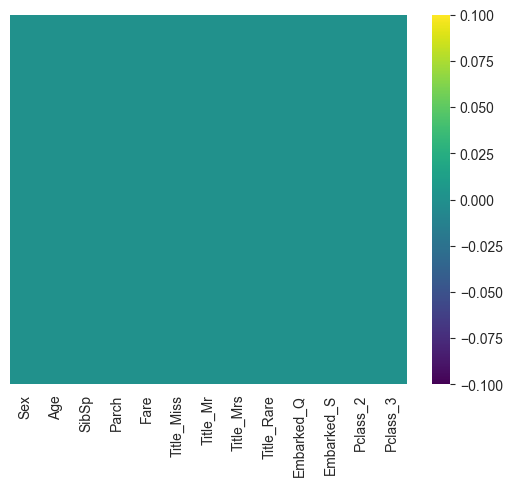

In [23]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

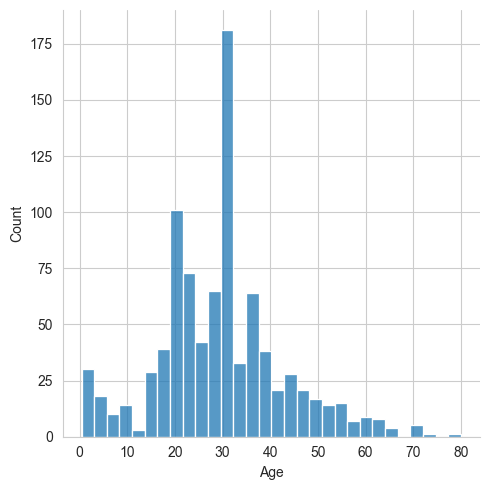

In [24]:
sns.displot(training_data['Age'],kde=False,bins=30)

## Ading new features

In [25]:
def add_features(data):
    # Family Size
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # IsAlone Feature
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0

    # Fare per Person
    data['FarePerPerson'] = data['Fare'] / data['FamilySize']
    data.drop('Fare', axis=1, inplace=True)
    
    return data

training_data = add_features(training_data)
test_data = add_features(test_data)

In [26]:
training_data.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,FamilySize,IsAlone,FarePerPerson
0,1,0,1,22.0,1,0,0,1,0,0,0,1,0,1,2,0,3.62500
1,2,1,0,38.0,1,0,0,0,1,0,0,0,0,0,2,0,35.64165
2,3,1,0,26.0,0,0,1,0,0,0,0,1,0,1,1,1,7.92500
3,4,1,0,35.0,1,0,0,0,1,0,0,1,0,0,2,0,26.55000
4,5,0,1,35.0,0,0,0,1,0,0,0,1,0,1,1,1,8.05000


## Splitting Data

In [27]:
X_train = training_data.drop('Survived', axis=1)  # Features
y_train = training_data['Survived']  # Target
print(y_train.shape)
print(X_train.shape)

(891,)
(891, 16)


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Separate features and target variable from your dataset
X = training_data.drop('Survived', axis=1)  # Features
y = training_data['Survived']  # Target variable

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)


# Predict on training and validation data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_valid)

# Define the calculate function
def calculate(y_train, y_valid, y_pred_train, y_pred_test):
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_valid, y_pred_test)
    p = precision_score(y_valid, y_pred_test)
    r= recall_score(y_valid, y_pred_test)
    return acc_train, acc_test, p, r

# Calculate the metrics
acc_train_rf, acc_test_rf, p, r = calculate(y_train, y_valid, y_pred_train, y_pred_test)

# Print the results
print(f"Training Accuracy: {acc_train_rf:.4f}")
print(f"Validation Accuracy: {acc_test_rf:.4f}")
print(f"Validation Precision: {p:.4f}")
print(f"Validation Recall: {r:.4f}")

Training Accuracy: 0.9053
Validation Accuracy: 0.8172
Validation Precision: 0.8523
Validation Recall: 0.6757


## Random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100,max_depth=15,min_samples_leaf=2,min_samples_split=10)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5)

In [84]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_valid)


acc_train_rf, acc_test_rf, p_rf, r_rf = calculate(y_train, y_valid, y_pred_train, y_pred_test)

print(f"Training Accuracy: {acc_train:.4f}")
print(f"Validation Accuracy: {acc_test:.4f}")
print(f"Validation Precision: {p:.4f}")
print(f"Validation Recall: {r:.4f}")

Training Accuracy: 0.9053
Validation Accuracy: 0.8172
Validation Precision: 0.8523
Validation Recall: 0.6757


## Random search

In [37]:
from sklearn.model_selection import RandomizedSearchCV

parameters={'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

rf=RandomForestClassifier()
clf=RandomizedSearchCV(rf,parameters, n_iter=100, n_jobs=1)
clf.fit(X_train,y_train) 

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]})

In [38]:
print(clf.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}


## Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters={
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
rf=RandomForestClassifier()
clf=GridSearchCV(rf,parameters)
clf.fit(X_train,y_train)

In [ ]:
print(clf.best_params_)

## ANN

In [52]:
from sklearn.neural_network import MLPClassifier
ann=MLPClassifier(hidden_layer_sizes=(32,4, 8, 16),activation='relu',alpha=0.001,solver='adam',learning_rate_init=0.01,batch_size=400,learning_rate="adaptive")
ann.fit(X_train,y_train)

MLPClassifier(alpha=0.001, batch_size=400, hidden_layer_sizes=(32, 4, 8, 16),
              learning_rate='adaptive', learning_rate_init=0.01)

In [99]:
y_pred_train = ann.predict(X_train)
y_pred_test = ann.predict(X_valid)


acc_train_ann, acc_test_ann, p_ann, r_ann = calculate(y_train, y_valid, y_pred_train, y_pred_test)

print(f"Training Accuracy: {acc_train_ann:.4f}")
print(f"Validation Accuracy: {acc_test_ann:.4f}")
print(f"Validation Precision: {p_ann:.4f}")
print(f"Validation Recall: {r_ann:.4f}")

Training Accuracy: 0.7961
Validation Accuracy: 0.8284
Validation Precision: 0.7686
Validation Recall: 0.8378


In [41]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
   
    'hidden_layer_sizes': [(32,8,8,32),(16,16,8,32),(32,8,4,2),(32,16,8,4)], 
    'activation': ['relu', 'tanh',"logistic"], 
    'solver': ['adam','lbfgs','sgd'],  
    'alpha': [0.0001, 0.001,0.002], 
    'learning_rate_init': [0.1,0.01, 0.001], 
    'batch_size': [10, 20, 40,50,60],
    'learning_rate': ['constant', 'adaptive'], 
    
}


ann=MLPClassifier()
clf=RandomizedSearchCV(estimator=ann, param_distributions=parameters)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=MLPClassifier(),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.002],
                                        'batch_size': [10, 20, 40, 50, 60],
                                        'hidden_layer_sizes': [(32, 8, 8, 32),
                                                               (16, 16, 8, 32),
                                                               (32, 8, 4, 2),
                                                               (32, 16, 8, 4)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.1, 0.01,
                                                               0.001],
                                        'solver': ['adam', 'lbfgs', 'sgd']})

In [42]:
print(clf.best_params_)

{'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (32, 8, 8, 32), 'batch_size': 10, 'alpha': 0.0001, 'activation': 'logistic'}


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters =  {
    'hidden_layer_sizes': [(2,4,8,10),(32,4,8,16),(32,8,8,32)], 
    'activation': ['relu', 'tanh',"logistic"], 
    'solver': ['adam','lbfgs','sgd'],  
    'alpha': [0.0001, 0.001,0.03,1e-5], 
    'learning_rate_init': [0.1,0.01, 0.001], 
    'batch_size': [10, 20, 400],  
    'learning_rate': ['constant', 'adaptive'],}

ann=MLPClassifier()
clf = GridSearchCV(ann, parameters)
clf.fit(X_train,y_train)

In [ ]:
print(clf.best_params_)

## LogisticRegression

In [95]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(solver='liblinear',max_iter=100)
lr.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

In [100]:
y_pred_train = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)

acc_train_lr, acc_valid_lr, p_lr, r_lr = calculate(y_train, y_valid, y_pred_train, y_pred_valid)
print(f"Training Accuracy: {acc_train_lr:.4f}")
print(f"Validation Accuracy: {acc_valid_lr:.4f}")
print(f"Validation Precision: {p_lr:.4f}")
print(f"Validation Recall: {r_lr:.4f}")

Training Accuracy: 0.8299
Validation Accuracy: 0.8097
Validation Precision: 0.8000
Validation Recall: 0.7207


## Desition Tree

In [79]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion="gini",max_depth=10,class_weight=None,min_samples_leaf=4,min_samples_split=2,splitter="random",max_features="log2",)
dt.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       splitter='random')

In [81]:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_valid)


acc_train_dt, acc_test_dt , p_dt, r_dt = calculate(y_train, y_valid, y_pred_train, y_pred_test)

print(f"Training Accuracy: {acc_train:.4f}")
print(f"Validation Accuracy: {acc_test:.4f}")
print(f"Validation Precision: {p:.4f}")
print(f"Validation Recall: {r:.4f}")

Training Accuracy: 0.8347
Validation Accuracy: 0.8209
Validation Precision: 0.8316
Validation Recall: 0.7117


In [44]:
from sklearn.model_selection import RandomizedSearchCV

parameters={
    'criterion': ["squared_error",'gini', 'entropy',"absolute_error","friedman_mse"],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']}

dt=DecisionTreeClassifier()
clf=RandomizedSearchCV(dt,parameters)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['squared_error', 'gini',
                                                      'entropy',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']})

In [45]:
print(clf.best_params_)

{'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': None}


## Comparison

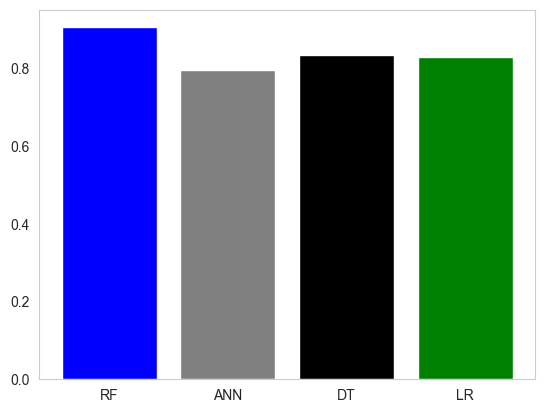

In [101]:
import matplotlib.pyplot as plt
acc_train=[acc_train_rf,acc_train_ann,acc_train_dt,acc_train_lr]
title=["RF","ANN","DT","LR"]
colors=["blue","gray","black","green"]
plt.bar(title,acc_train,color=colors)
plt.grid()
plt.show()

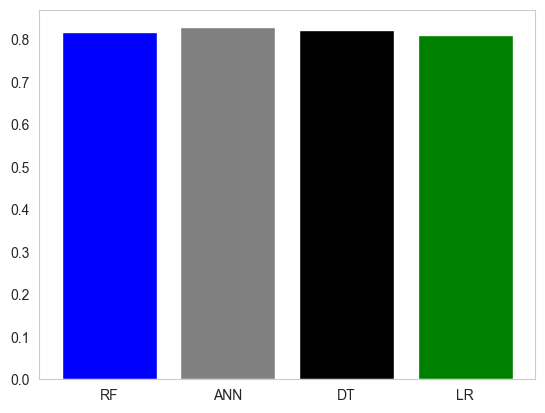

In [102]:
import matplotlib.pyplot as plt
acc_test=[acc_test_rf,acc_test_ann,acc_test_dt,acc_test_lr]
title=["RF","ANN","DT","LR"]
colors=["blue","gray","black","green"]
plt.bar(title,acc_test,color=colors)
plt.grid()
plt.show()

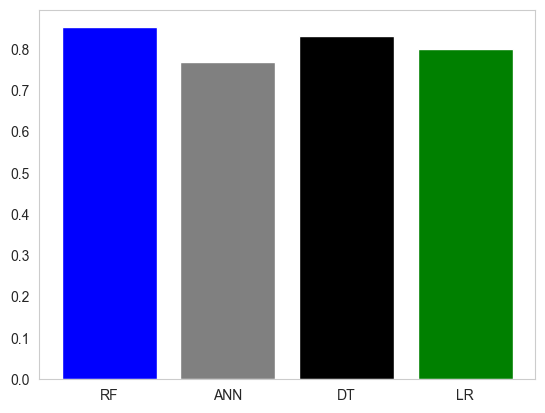

In [103]:
import matplotlib.pyplot as plt
p=[p_rf,p_ann,p_dt,p_lr]
title=["RF","ANN","DT","LR"]
colors=["blue","gray","black","green"]
plt.bar(title,p,color=colors)
plt.grid()
plt.show()


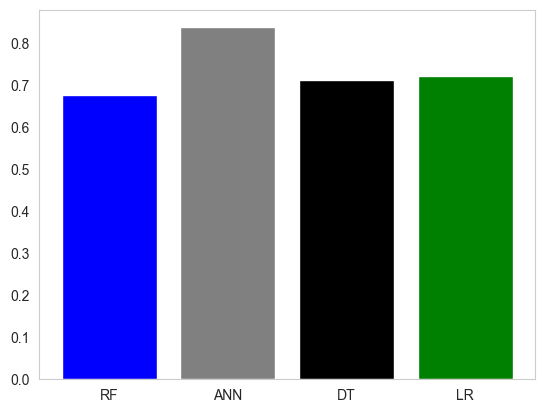

In [104]:
import matplotlib.pyplot as plt
r=[r_rf,r_ann,r_dt,r_lr]
title=["RF","ANN","DT","LR"]
colors=["blue","gray","black","green"]
plt.bar(title,r,color=colors)
plt.grid()
plt.show()